# Semi-supervised Variational Encoder for Vulnerability Detection

###### Yufan Zhuang (yz3453)  
###### Columbia University

## 1. Introduction

The purpose of this project is to utilize the **unlabeled data** to help with the performance and generalization of **supervised classifiers**.   

In this project, the target domain is selected as the vulnerability detection. The reason for choosing this domain is two-fold:
first, there are trillions of free source code available on hosting websites like Github, Gitlab and Bitbucket; second, labeled code is expensive especially when the vulnerabilities and programming languages both change over time.

In [1]:
# Loading Libraries
%load_ext autoreload
%autoreload 2
%matplotlib inline 
import torch
from torch import nn
import pandas as pd
import numpy as np
from ss_vae import SSVAE, get_accuracy
from dataset_ss import DataSet, DataEntry
import matplotlib.pyplot as plt
import pyro
import seaborn as sns
import pyro.distributions as dist

## 2. Background

Recent advancements in Deep Learning (DL) have attracted researchers from diverse domains. The pipeline for a deep learning task, in any domain, commonly consists of:

1. Pre-processing the Data
2. Training the Model
3. Validating the Model

We give an overview of the components of the pipeline, shown below, and discuss recent research for each component when deep learning is applied to detection of vulnerabilities in source code (referred to as *vd* hereafter). 

<img src="./figures/pipeline.jpg">

### 2.1 Code Normalization
Developers may use a wide variety of identifier names in their source code, chosen according to the project policy, business requirements, etc. When analyzing source code with a diverse set of possible tokens representing identifiers, occurrence of individual identifiers may become very sparse --- and hence is very difficult for DL models to learn the correct hypotheses. To solve this problem, researchers have proposed several techniques to normalize tokens and/or identifiers. This can be achieved in several ways, ranging from mapping tokens to corresponding type/generic names to transformation of a large sparse identifier name space to a dense space with pre-specified rules. Note that this kind of transformation can be learned as well. 

An example of code normalization is the following:

In [3]:
#The original code
print(pd.read_csv('./data/cwe119.csv')['sample'][0])


ZIP_FILENAME_LEN, NULL, 0, NULL, 0 )
char *psz_fileName = calloc( ZIP_FILENAME_LEN, 1 );
if( unzGetCurrentFileInfo( file, p_fileInfo, psz_fileName,
vlc_array_append( p_filenames, strdup( psz_fileName ) );
free( psz_fileName );



In [4]:
#The Tokenized code
with open('./data/cwe119.tok') as df:
    for _ in df:
        print(_); break

ZIP_FILENAME_LEN , NULL , 0 , NULL , 0 char * psz_fileName = calloc ZIP_FILENAME_LEN , 1 if unzGetCurrentFileInfo file , p_fileInfo , psz_fileName , vlc_array_append p_filenames , strdup psz_fileName free psz_fileName



In [5]:
#Normalized Code
with open('./data/cwe119.data') as df:
    for _ in df:
        print(_); break

DEC , NULL , LITERAL , NULL , LITERAL char * IDENT = IDENT IDENT , LITERAL if IDENT IDENT , IDENT , IDENT , IDENT IDENT , IDENT IDENT IDENT IDENT



### 2.2 Code Segmentation

Since a security vulnerability can be caused by a single line of code (take misuse of *strcpy* as an example), it may be tempting to include in the training data all the lines from every source file/function/method. But this might make the training data very noisy, reducing generalization because of extraneous noise. 

In order to overcome this, *segmenting* the source of vulnerability seems necessary. In this context, segmenting means cutting off the unrelated parts of code by either forward/backward slicing or other methods.  The first difficulty in doing so is that it is not easy to collect a well-annotated dataset that is sufficient for a deep learning task. Some people use synthetic datasets in which vulnerabilities are automatically or manually injected to overcome this problem. However, this approach may induce bad generalization, as we will discuss in later sections. The second difficulty is that there are complicated scenarios where multiple functions are involved in a single vulnerability, which makes code segmentation a non-trivial task.  

The following is from [SySeVR: A Framework for Using Deep Learning to Detect Software Vulnerabilities](https://arxiv.org/abs/1807.06756)

<img src="./figures/seg.PNG">

### 2.3 Deep Learning Models

CNN and RNN (LSTM, BiLSTM, GRU, BiGRU) were wildly used in recent research.

At a high level, the goal of all these models is to take the input and transform it to the output space. DNNs consider the fixed length input, typically a real-valued vector representing the data example at hand. Converting an example to a real-valued vector is called feature extraction. Oftentimes, it is not clear what features of the data are most important for the task, hence feature extraction is hard and may lead to sub-optimal solutions. 

RNNs (and also its variations --- LSTM, GRU, etc), on the other hand, are sequential models, which are highly effective when the input is a variable length sequence of data. For instance, in case of classifying a code whether it is vulnerable or not, the input is a variable length sequence of tokens. While processing part of sequential input, RNNs update its hidden state. This hidden state are designed in a way that it can store the information from the sequential input. Being sequential model, one drawback of RNN is, it is not very effective in modeling the non-linear dependency between parts of the input. There are several other improvement proposed over RNN (and also LSTM, GRU), bi-directional RNN -- which can model dependency in both direction, tree-RNN -- which can model tree structured data representation, graph-NN -- which can model graph structured data etc. But each of which is more expensive than it predecessor.  

CNNs are highly effective for detecting higher level feature by extraction of spatial feature through convolution filters. They are widely used in image processing and text processing.

How CNN is used in sequence modeling, from [Automated Vulnerability Detection in Source Code Using Deep Representation Learning](https://arxiv.org/pdf/1807.04320.pdf)

<img src="./figures/cnn.PNG">

### 2.4 Validation

Given a well-optimized model, how does anybody know whether it will work on previously unseen data? In theoretical machine learning, there have been recent advancements in analyzing generalization of two-layer neural networks with probably approximately correct (PAC) learning framework and Rademacher complexity. However, state-of-the-art mathematical generalization analysis requires extremely wide networks and are confined to shallow architectures, which makes them far from ideal for practical use.

Without perfect theoretical tools, people use a train/test split and cross-validation to validate their models' performance. The procedure is simply leaving part of the training data aside in training, then evaluate the model's performance at the end of training based on this left-out set of data. This is a simple yet powerful empirical trick and has been employed in much applied machine learning research. But these empirical techniques do not guarantee that the model would perform at the same level under different scenarios, and it is this paper's purpose to explore when, why and how a deep learning model will generalize well on unseen data. 

## 3. Datasets

We include two datasets for our project:
1. Static Analysis Tool Exposition (SATE) IV Juliet 
2. VulDeePecker

SATE IV Juliet is a dataset managed by NIST, it can be accessed from [here](https://samate.nist.gov/SATE4.html). VulDeePecker is a dataset created from SATE IV Juliet by segmenting from [this paper](https://arxiv.org/abs/1801.01681).

Both datasets are in C++/C language. We list out some basic properties of these two dataset.

In [6]:
import cross_dataset
import cross_trainer
from sklearn.metrics import f1_score
def load_data(data_file, label_file, data = None):
    parser = None
    if data is None: data = cross_dataset.DataSet()
    with open(data_file) as df:
        with open(label_file) as dl:
            for line, label in zip(df, dl):
                entry = cross_dataset.DataEntry(data, line.strip(), int(label))
                data.add_data_entry(entry)
    return data

In [15]:
data_all = load_data(data_file = 'data/cwe399.data', label_file = 'data/cwe399.label')
data_all = load_data(data_file = 'data/cwe119.data', label_file = 'data/cwe119.label', data = data_all)
data_all = load_data(data_file = 'data/juliet.data', label_file = 'data/juliet.label', data = data_all)
data_all.build_vocabulary(1000)

print('For SATE IV Juliet')
data_sate = load_data(data_file = 'data/juliet.data', label_file = 'data/juliet.label')
data_sate.init_data_set(vocab_size=1000, batch_size=32, test_percentage=0.1, vocab = data_all.vocab)

print('For VulDeePecker')
data_gad = load_data(data_file = 'data/cwe399.data', label_file = 'data/cwe399.label')
data_gad = load_data(data_file = 'data/cwe119.data', label_file = 'data/cwe119.label', data = data_gad)
data_gad.init_data_set(vocab_size=1000, batch_size=32, test_percentage=0.1, vocab = data_all.vocab)

Total Number of Words 18707809
Unique Words :  137
Vocab Size :  137
For SATE IV Juliet
Raw Data Size: 192146
Portion of buggy lines: 0.4961851925098623
Train Set Size: 172879
Test Set Size: 19267
For VulDeePecker
Raw Data Size: 61638
Portion of buggy lines: 0.2875661118141406
Train Set Size: 55468
Test Set Size: 6170


Size of Vocabulary after normalization: 137

**For SATE IV Juliet**

Number of samples: 192146

Portion of buggy data: 0.4962

**For VulDeePecker Dataset**

Number of samples: 61638

Portion of buggy data: 0.2876

## 4. How are the current models generalizing?

We conduct a cross generalizing test.

In [16]:
from cross_model import RnnModel, ConvModel, BiRnnModel
datasets = [data_sate, data_gad]
df_cnn = np.ndarray(shape=(2,2), dtype=float)
df_rnn = np.ndarray(shape=(2,2), dtype=float)
df_brnn = np.ndarray(shape=(2,2), dtype=float)

In [17]:
for i, data in enumerate(datasets):
    model = ConvModel(data.vocab, emb_dim=128)
    model.train()
    criterion = torch.nn.NLLLoss(size_average=False)
    optim = torch.optim.Adam(model.parameters())
    cross_trainer.train(model, criterion, optim, data, 10000)
    #CNN Training Complete
    model.eval()
    for j, test in enumerate(datasets):
        print(i, j)
        #test_sequences, test_masks, test_labels = test.get_test_data()
        #print(data.vocab)
        #print(type(data.vocab))            
        predicted_output, original_output = cross_trainer.decode(model, test)
        #original_output = test_labels.cpu().data.numpy()
        accuracy = cross_trainer.accuracy_score(original_output, predicted_output)
        f1_cnn = f1_score(original_output, predicted_output)
        print('Accuracy of CNN Model : ', accuracy)
        df_cnn[i,j] = accuracy
        print('F1 of CNN Model : ', f1_cnn)
        test.initialize_test_batch()
    #FOR BiLSTM
    birnn_model = BiRnnModel(data.vocab, emb_dim=128, hidden_size=64)
    birnn_model.cuda()
    birnn_model.train()
    criterion = torch.nn.NLLLoss(size_average=False)
    optim = torch.optim.Adam(birnn_model.parameters())
    cross_trainer.train(birnn_model, criterion, optim, data, 10000)
    # RNN Training Complete
    birnn_model.eval()
    for j, test in enumerate(datasets):
        print(i,j)
        predicted_output, original_output = cross_trainer.decode(birnn_model, test)
        accuracy = cross_trainer.accuracy_score(original_output, predicted_output)
        f1_rnn = f1_score(original_output, predicted_output)
        print('Accuracy of BiLSTM Model    \t: ', accuracy)
        df_brnn[i,j] = accuracy
        print('F1 of BiLSTM Model : ', f1_rnn)
        test.initialize_test_batch()
    # FOR LSTM MODEL
    rnn_model = RnnModel(data.vocab, emb_dim=128, hidden_size=64)
    rnn_model.cuda()
    rnn_model.train()
    criterion = torch.nn.NLLLoss(size_average=False)
    optim = torch.optim.Adam(rnn_model.parameters())
    cross_trainer.train(rnn_model, criterion, optim, data, 10000)
    # RNN Training Complete
    rnn_model.eval()
    for j, test in enumerate(datasets):
        print(i, j)
        predicted_output, original_output = cross_trainer.decode(rnn_model, test)
        accuracy = cross_trainer.accuracy_score(original_output, predicted_output)
        f1_rnn = f1_score(original_output, predicted_output)
        print('Accuracy of RNN Model    \t: ', accuracy)
        df_rnn[i,j] = accuracy
        print('F1 of RNN Model : ', f1_rnn)
        test.initialize_test_batch()

/local/yz3453/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


0 0
603
Accuracy of CNN Model :  87.51686909581646
F1 of CNN Model :  0.8827115337722506
0 1
193
Accuracy of CNN Model :  40.265845355811315
F1 of CNN Model :  0.42806146205183926
0 0
603
Accuracy of BiLSTM Model    	:  90.13806706114399
F1 of BiLSTM Model :  0.9042724707779122
0 1
193
Accuracy of BiLSTM Model    	:  43.03776949262441
F1 of BiLSTM Model :  0.45788336933045354
0 0
603
Accuracy of RNN Model    	:  90.27821031869615
F1 of RNN Model :  0.9010094603879287
0 1
193
Accuracy of RNN Model    	:  34.85167774355649
F1 of RNN Model :  0.31122536418166236
1 0
603
Accuracy of CNN Model :  46.75075262119797
F1 of CNN Model :  0.5112201629424937
1 1
193
Accuracy of CNN Model :  82.80110228562165
F1 of CNN Model :  0.8892368723248774
1 0
603
Accuracy of BiLSTM Model    	:  55.10225267310288
F1 of BiLSTM Model :  0.6672308994383319
1 1
193
Accuracy of BiLSTM Model    	:  88.63673204733344
F1 of BiLSTM Model :  0.9222751968067414
1 0
603
Accuracy of RNN Model    	:  55.055538253918826
F1

**For CNN Model**

| Train\Test | SATE IV Juliet   | VulDeePecker
|------|------|------|
|   SATE IV Juliet  | 87.51| 40.27   |
|   VulDeePecker    |  46.75    |  82.80   |

**For LSTM Model**

| Train\Test | SATE IV Juliet   | VulDeePecker
|------|------|------|
|   SATE IV Juliet  | **90.28**| 34.85   |
|   VulDeePecker    |  55.06    | 87.92   |

**For BiLSTM Model**

| Train\Test | SATE IV Juliet   | VulDeePecker
|------|------|------|
|   SATE IV Juliet  |90.14| **43.04**   |
|   VulDeePecker    |  **55.10**    |  **88.64**  |

The result indicates that the generalization is bad for these models, thus we might a more powerful model.

## 5. Semi-supervised VAE

We believe that we might be able to obtain a better model in both performance and generalizability by leveraging code in the wild that are unlabeled. The way this VAE is designed is the following.

The architechture of the Semi-supervised VAE
<img src="./figures/ssvae.jpg">

Loss function

$L_{total\: loss} = \sum_{i \in \Omega_{supervised}} L(x_i, y_i) + \sum_{i \in \Omega_{unsupervised}} U(x_i) + \alpha \sum_{i \in \Omega_{supervised}} [-\ln(q(y_i|x_i)]$

We will go through each part in details.

In [ ]:
class SSVAE(nn.Module):
    """
    This class encapsulates the parameters (neural networks) and models & guides needed to train a
    semi-supervised variational auto-encoder
    
    :param output_size: size of the tensor representing the class label (0 or 1 denotes buggy or non-buggy)
    :param input_size: size of the tensor 
    :param z_dim: size of the tensor representing the latent random variable z
    """
    def __init__(self, data, output_size=2, input_size=784, z_dim=50, hidden_layers=(500,),
                 config_enum=None, use_cuda=False, aux_loss_multiplier=None):

        super(SSVAE, self).__init__()

        # initialize the class with all arguments provided to the constructor
        self.output_size = output_size
        self.input_size = input_size
        self.z_dim = z_dim
        self.hidden_layers = hidden_layers
        self.allow_broadcast = config_enum == 'parallel'
        self.use_cuda = use_cuda
        self.aux_loss_multiplier = aux_loss_multiplier

        # define and instantiate the neural networks representing
        # the paramters of various distributions in the model
        self.setup_networks(data)

    def setup_networks(self, data):

        z_dim = self.z_dim
        hidden_sizes = self.hidden_layers
        #emb_dim = self.emb_dim

        # define the neural networks used later in the model and the guide.
        # these networks are LSTMs
        self.encoder_y = classifier_LSTM(vocabulary=data.vocab, emb_dim = 128, hidden_size=64)


        # a split in the final layer's size is used for multiple outputs
        # and potentially applying separate activation functions on them
        # e.g. in this network the final output is of size [z_dim,z_dim]
        # to produce loc and scale, and apply different activations [None,Exp] on them
        self.encoder_z = encoder_LSTM(vocabulary=data.vocab, emb_dim = 128, enc_hidden_size = 64, z_hidden_size = z_dim, hidden_sizes = [32])

        self.decoder = decoder_LSTM(vocabulary=data.vocab, hidden_size=64, z_hidden_size=z_dim)

        self.one_hot_emb_x = nn.Embedding(data.vocab.count, data.vocab.count)
        self.one_hot_emb_x.weight.data = torch.eye(data.vocab.count)

        # using GPUs for faster training of the networks
        if self.use_cuda:
            self.cuda()

    def model(self, xs, ys=None):
        """
        The model corresponds to the following generative process:
        p(z) = normal(0,I)              # programming style (latent)
        p(y|x) = categorical(I/10.)     # which category (semi-supervised)
        p(x|y,z) = bernoulli(loc(y,z))   # a sequence
        loc is given by a neural network  `decoder`

        :param xs: a batch of sequence from programs
        :param ys: (optional) a batch of the class labels i.e. 1 for vulnerable 0 for safe
        :return: None
        """
        # register this pytorch module and all of its sub-modules with pyro
        pyro.module("ss_vae", self)

        max_seq_len = max([len(x) for x in xs])

        batch_size = xs.size(0)
        with pyro.plate("data"):

            # sample the programming style from the constant prior distribution
            prior_loc = xs.new_zeros([batch_size, self.z_dim]).float()
            prior_scale = xs.new_ones([batch_size, self.z_dim]).float()
            zs = pyro.sample("z", dist.Normal(prior_loc, prior_scale).to_event(1))

            # if the label y is supervised, sample from the
            # constant prior, otherwise, observe the value (i.e. score it against the constant prior)

            alpha_prior = xs.new_ones([batch_size, self.output_size]).float() / (1.0 * self.output_size)
            ys = pyro.sample("y", dist.OneHotCategorical(alpha_prior), obs=ys)
            # finally, score the sequence (x) using the handwriting style (z) and
            # the class label y against the
            # parametrized distribution p(x|y,z) = bernoulli(decoder(y,z))
            # where `decoder` is a neural network
            loc = self.decoder.forward([zs, ys], max_seq_len)
            xs_oh = self.one_hot_emb_x(xs).data
            for t in range(1, max_seq_len+1):
                if (len(loc.size()) > 3):
                    pyro.sample("obs_x_%d" % t,
                            dist.Bernoulli(loc[:,:,t-1,:]).to_event(1),
                            obs=xs_oh[:, t - 1, :])
                else:
                    pyro.sample("obs_x_%d" % t,
                                dist.Bernoulli(loc[:, t - 1, :]).to_event(1),
                                obs=xs_oh[:, t - 1, :])

            # return the loc so we can visualize it later
            return loc

    def guide(self, xs, ys=None):
        """
        The guide corresponds to the following:
        q(y|x) = categorical(alpha(x))              # infer class
        q(z|x,y) = normal(loc(x,y),scale(x,y))       # infer programming style from a sequence and the class label
        loc, scale are given by a neural network `encoder_z`
        alpha is given by a neural network `encoder_y`

        :param xs: a batch of sequence from programs
        :param ys: (optional) a batch of the class labels i.e. 1 for vulnerable 0 for safe
        :return: None
        """
        # inform Pyro that the variables in the batch of xs, ys are conditionally independent
        with pyro.plate("data"):

            # if the class label is not supervised, sample
            # (and score) the class with the variational distribution
            # q(y|x) = categorical(alpha(x))
            if ys is None:
                alpha = self.encoder_y.forward(xs)
                ys = pyro.sample("y", dist.OneHotCategorical(alpha))

            # sample (and score) the latent programming-style with the variational
            # distribution q(z|x,y) = normal(loc(x,y),scale(x,y))
            loc, scale = self.encoder_z.forward([xs, ys])
            pyro.sample("z", dist.Normal(loc, scale).to_event(1))

    def classifier(self, xs):
        """/
        classify a sequence

        :param xs: a batch of sequence from programs
        :return: a batch of the corresponding class labels (as one-hots)
        """
        alpha = self.encoder_y.forward(xs)

        res, ind = torch.topk(alpha, 1)

        return ind.squeeze().float()

    def model_classify(self, xs, ys=None):
        """
        this model is used to add an auxiliary (supervised) loss as described in the
        Kingma et al., "Semi-Supervised Learning with Deep Generative Models".
        """
        # register all pytorch (sub)modules with pyro
        pyro.module("ss_vae", self)

        # inform Pyro that the variables in the batch of xs, ys are conditionally independent
        with pyro.plate("data"):
            # this here is the extra term to yield an auxiliary loss that we do gradient descent on
            if ys is not None:
                alpha = self.encoder_y.forward(xs)
                with pyro.poutine.scale(scale=self.aux_loss_multiplier):
                    pyro.sample("y_aux", dist.OneHotCategorical(alpha), obs=ys)

    def guide_classify(self, xs, ys=None):
        """
        dummy guide function to accompany model_classify in inference
        """
        pass

## 6. Evaluation

We evaluate our model from two perspectives, quantitativly and qualitativly.

### 6.1 Quantitative Evaluation

We evaluate our trained model based on its accuracy and generalizability. 

Loading supervised data and unsupurvised data

In [2]:
data = DataSet()
data_file =  './data/juliet.data'
label_file = './data/juliet.label'

In [3]:
wild_data_file = ['./data/cwe119.data', './data/cwe399.data']
wild_label_file = ['./data/cwe119.label', './data/cwe399.label']

In [4]:
#Add Supervised Data
with open(data_file) as df:
    with open(label_file) as dl:
        for line, label in zip(df, dl):
            entry = DataEntry(data, line.strip(), int(label))
            data.add_data_entry(entry)

# Add Unsurpervised Data
for wild_df, wild_label in zip(wild_data_file, wild_label_file):
    with open(wild_df) as df:
        with open(wild_label) as dl:
            for line, label in zip(df, dl):
                entry = DataEntry(data, line.strip(), label = int(label),meta_data=-1)
                data.add_data_entry(entry)

In [5]:
#Initialize Dataset
data.init_data_set(vocab_size=1000, batch_size = 32, test_percentage=0.1)

Total Number of Words 18707809
Unique Words :  137
Vocab Size :  137
Raw Data Size: 253784


In [6]:
#Loading the pretrained model
model = torch.load('./save_points/vae_9.pt')

/home/yz3453/anaconda3/lib/python3.7/site-packages/torch/serialization.py:434: SourceChangeWarning: source code of class 'ss_vae.SSVAE' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/yz3453/anaconda3/lib/python3.7/site-packages/torch/serialization.py:434: SourceChangeWarning: source code of class 'vae_model.classifier_LSTM' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


In [11]:
def get_accuracy(data_loader, classifier_fn, batch_size):
    """
    compute the accuracy over the supervised training set or the testing set
    """
    predictions, actuals = [], []
    test_batches = len(data_loader.test_batch_indices)
    print(test_batches)

    # use the appropriate data loader

    for i in range(test_batches):
        sequences, masks, labels = data_loader.get_next_batch_test_data()
        # use classification function to compute all predictions for each batch
        predictions.append(classifier_fn(sequences))
        actuals.append(labels)

    # compute the number of accurate predictions
    accurate_preds = 0
    for pred, act in zip(predictions, actuals):
        for i in range(pred.size(0)):
            v = torch.sum(pred[i] == act[i])
            accurate_preds += v.item()

    # calculate the accuracy between 0 and 1
    accuracy = (accurate_preds * 1.0) / (len(predictions) * batch_size)
    data_loader.initialize_test_batch()
    return accuracy

In [9]:
data.initialize_test_batch()
test_accuracy = get_accuracy(data, model.classifier, 32)
print("Accuracy on the testset:", test_accuracy)

603
Accuracy on the testset: 0.9031405472636815


So the accuracy of this classifier is better than the previous architechtures.

In [13]:
data.initialize_unsup_batch()
predictions, actuals = [], []
test_batches = len(data.unsup_batch_indices)
print("Number batches of Wild Dataset", test_batches)
# use the appropriate data loader

for i in range(test_batches):
    sequences, masks, labels, max_seq_len = data.get_next_batch_train_unsup_data()
    # use classification function to compute all predictions for each batch
    predictions.append(model.classifier(sequences))
    actuals.append(labels.float())

# compute the number of accurate predictions
accurate_preds = 0
for pred, act in zip(predictions, actuals):
    for i in range(pred.size(0)):
        #print(pred[i], act[i])
        v = torch.sum(pred[i] == act[i])
        accurate_preds += v.item()

# calculate the accuracy between 0 and 1
accuracy = (accurate_preds * 1.0) / (len(predictions) * 32)
print("Accuracy on the unsupervised set:", accuracy)

Number batches of Wild Dataset 1927
Accuracy on the testset: 0.3625454073689673


In [9]:
#Loading the model trained on VulDeePecker
model = torch.load('./save_points/vaeo_3.pt')

In [10]:
data = DataSet()
#Add Supervised Data
with open(data_file) as df:
    with open(label_file) as dl:
        for line, label in zip(df, dl):
            entry = DataEntry(data, line.strip(), int(label),meta_data=-1)
            data.add_data_entry(entry)

# Add Unsurpervised Data
for wild_df, wild_label in zip(wild_data_file, wild_label_file):
    with open(wild_df) as df:
        with open(wild_label) as dl:
            for line, label in zip(df, dl):
                entry = DataEntry(data, line.strip(), label = int(label))
                data.add_data_entry(entry)

In [12]:
#Initialize Dataset
data.init_data_set(vocab_size=1000, batch_size = 32, test_percentage=0.1)

Total Number of Words 18707809
Unique Words :  137
Vocab Size :  137
Raw Data Size: 253784


In [13]:
data.initialize_test_batch()
test_accuracy = get_accuracy(data, model.classifier, 32)
print("Accuracy on the testset:", test_accuracy)

196
Accuracy on the testset: 0.8667091836734694


In [14]:
data.initialize_unsup_batch()
predictions, actuals = [], []
test_batches = len(data.unsup_batch_indices)
print("Number batches of Wild Dataset", test_batches)
# use the appropriate data loader

for i in range(test_batches):
    sequences, masks, labels, max_seq_len = data.get_next_batch_train_unsup_data()
    # use classification function to compute all predictions for each batch
    predictions.append(model.classifier(sequences))
    actuals.append(labels.float())

# compute the number of accurate predictions
accurate_preds = 0
for pred, act in zip(predictions, actuals):
    for i in range(pred.size(0)):
        #print(pred[i], act[i])
        v = torch.sum(pred[i] == act[i])
        accurate_preds += v.item()

# calculate the accuracy between 0 and 1
accuracy = (accurate_preds * 1.0) / (len(predictions) * 32)
print("Accuracy on the unsupervised set:", accuracy)

Number batches of Wild Dataset 6005
Accuracy on the unsupervised set: 0.5001821398834305


**For SSVAE Model**

| Train\Test | SATE IV Juliet   | VulDeePecker
|------|------|------|
|   SATE IV Juliet  |90.31| 36.25   |
|   VulDeePecker    |  50.02    |  86.67  |

**For LSTM Model**

| Train\Test | SATE IV Juliet   | VulDeePecker
|------|------|------|
|   SATE IV Juliet  | 90.28| 34.85   |
|   VulDeePecker    |  55.06    | 87.92   |

### 6.2 Qualitative Evaluation

We can also plot the embeddings in the latent space. (take SATE IV Juliet Data as an example)

In [19]:
data = DataSet()
#Add Supervised Data
with open(data_file) as df:
    with open(label_file) as dl:
        for line, label in zip(df, dl):
            entry = DataEntry(data, line.strip(), int(label))
            data.add_data_entry(entry)

# Add Unsurpervised Data
for wild_df, wild_label in zip(wild_data_file, wild_label_file):
    with open(wild_df) as df:
        with open(wild_label) as dl:
            for line, label in zip(df, dl):
                entry = DataEntry(data, line.strip(), label = int(label),meta_data=-1)
                data.add_data_entry(entry)

In [20]:
#Initialize Dataset
data.init_data_set(vocab_size=1000, batch_size = 32, test_percentage=0.1)

Total Number of Words 18707809
Unique Words :  137
Vocab Size :  137
Raw Data Size: 253784


In [12]:
#Loading the pretrained model
model = torch.load('./save_points/vae_9.pt')

In [21]:
data.initialize_test_batch()
test_batches = len(data.test_batch_indices)
print(test_batches)
#Get the First Batch
sequences, masks, labels = data.get_next_batch_test_data()
output_t = labels
labels = one_hot_emb_y(labels.long()).data
z_loc, z_scale = model.encoder_z([sequences,labels])
output_hid = z_loc
for i in range(test_batches-1):
    sequences, masks, labels = data.get_next_batch_test_data()
    output_t = torch.cat((output_t, labels))
    labels = one_hot_emb_y(labels.long()).data
    z_loc, z_scale = model.encoder_z([sequences,labels])
    output_hid = torch.cat((output_hid, z_loc))

603


In [22]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(output_hid.data.cpu().numpy())

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 19266 samples in 0.049s...
[t-SNE] Computed neighbors for 19266 samples in 2.923s...
[t-SNE] Computed conditional probabilities for sample 1000 / 19266
[t-SNE] Computed conditional probabilities for sample 2000 / 19266
[t-SNE] Computed conditional probabilities for sample 3000 / 19266
[t-SNE] Computed conditional probabilities for sample 4000 / 19266
[t-SNE] Computed conditional probabilities for sample 5000 / 19266
[t-SNE] Computed conditional probabilities for sample 6000 / 19266
[t-SNE] Computed conditional probabilities for sample 7000 / 19266
[t-SNE] Computed conditional probabilities for sample 8000 / 19266
[t-SNE] Computed conditional probabilities for sample 9000 / 19266
[t-SNE] Computed conditional probabilities for sample 10000 / 19266
[t-SNE] Computed conditional probabilities for sample 11000 / 19266
[t-SNE] Computed conditional probabilities for sample 12000 / 19266
[t-SNE] Computed conditional probabilities for sa

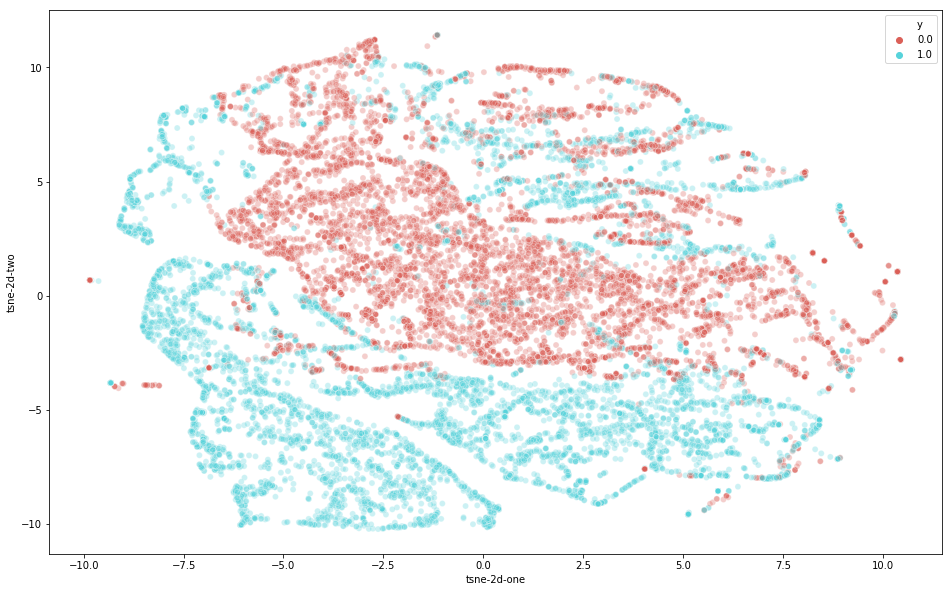

In [23]:
#Create the TSNE plot for the hidden representation
df_subset = pd.DataFrame()
df_subset['tsne-2d-one'] = tsne_results[:,0]
df_subset['tsne-2d-two'] = tsne_results[:,1]
df_subset['y'] = output_t.data.cpu().numpy()
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
    palette=sns.color_palette("hls", 2),
    data=df_subset,
    legend="full",
    alpha=0.3
)

The two classes are pretty separable in the TSNE plot, which indicates that the hidden representation has meaningful interpretations.

Can we also flip the label such that an automated fix is generated by the decoder?

In [24]:
data.initialize_batch()
#Get the First Batch
sequences, masks, labels, max_len = data.get_next_batch_train_data()

flip_labels = 1- labels
flip_labels = one_hot_emb_y(flip_labels.long()).data
labels = one_hot_emb_y(labels.long()).data
z_loc, z_scale = model.encoder_z([sequences,labels], max_len)

zs = pyro.sample("z", dist.Normal(z_loc, z_scale).to_event(1))

loc = model.decoder([zs, labels], max_len).data.cpu().numpy()

flip_loc = model.decoder([zs, flip_labels], max_len).data.cpu().numpy()

In [25]:
loc.shape

(1, 32, 144, 142)

In [26]:
sequences.shape

torch.Size([32, 144])

In [43]:
idx = 31
#The original sequence
for _ in sequences.data.cpu().numpy()[idx,:]:
    print(data.vocab.get_token(_))

<START>
void
DEC
wchar_t
*
DEC
=
IDENT
<END>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>


In [44]:
#Prior to flip
for _ in loc[0,idx,:,:]:
    print(data.vocab.get_token(np.argmax(_)))


<START>
void
DEC
DEC
DEC
DEC
DEC
IDENT
IDENT
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>


In [45]:
#After flip
for _ in flip_loc[0,idx,:,:]:
    print(data.vocab.get_token(np.argmax(_)))

<START>
void
DEC
DEC
DEC
IDENT
DEC
IDENT
IDENT
IDENT
IDENT
IDENT
IDENT
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>


## 7. Conclusion & Future Work

We set up this semi-supervised framework for sequence classification. The model is evaluated both quantitatively and qualitatively. We observe some interesting results, including:

1. The semi-supervised framework might be able to help with generalizability.
2. The differentiable embedding space for programs has more potential applications since one key obstacle for program modeling is discontinuity
3. Flipping the label in decoder produces some interesting result. Not very meaningful at this stage, but we might use a more complicated model later.

Couple things we left for future work:

1. A more complicated encoder model (probably I will try BiLSTM and tree-LSTM later)
2. A better decoder structure (maybe deep HMM?)
3. GAN style model for better sequence recovery
4. Put model on raw symbol level sequence 